<a href="https://colab.research.google.com/github/lydialydia-lydia/rwa-stablecoin-risk-spark/blob/main/03_liquidity_stress.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
%cd /content
!rm -rf rwa-stablecoin-risk-spark
!git clone https://github.com/lydialydia-lydia/rwa-stablecoin-risk-spark.git
%cd /content/rwa-stablecoin-risk-spark
!ls
!ls data

/content
Cloning into 'rwa-stablecoin-risk-spark'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 30 (delta 11), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (30/30), 212.56 KiB | 3.79 MiB/s, done.
Resolving deltas: 100% (11/11), done.
/content/rwa-stablecoin-risk-spark
01_data_fetch.ipynb  data  figures  LICENSE  notebooks	README.md
spark_assets_proxy.csv


In [20]:
import pandas as pd

tvl = pd.read_csv("data/spark_assets_proxy.csv")
tvl["date"] = pd.to_datetime(tvl["date"])
tvl.head()

,date,assets_proxy_usd
0,2023-05-01,31.0
1,2023-05-02,30.0
2,2023-05-03,31.0
3,2023-05-04,31.0
4,2023-05-05,31.0


In [21]:
import numpy as np
import pandas as pd

A0 = float(tvl["assets_proxy_usd"].iloc[-1])
target_cr_now = 1.05
L0 = A0 / target_cr_now

redemption_shocks = np.array([0.05, 0.20, 0.40])   # % of liabilities redeemed
settlement_days = np.array([0, 1, 2])              # 0=instant, 1=T+1, 2=T+2

liquid_frac_same_day = 0.30  # assume 30% of assets can be liquidated same day
haircut = 0.03               # liquidation friction

rows=[]
for r in redemption_shocks:
    cash_need = L0 * r
    for d in settlement_days:
        if d == 0:
            cash_avail = A0 * liquid_frac_same_day * (1 - haircut)
        elif d == 1:
            cash_avail = A0 * (liquid_frac_same_day + 0.20) * (1 - haircut)  # +20% becomes available next day
        else:
            cash_avail = A0 * (liquid_frac_same_day + 0.20 + 0.20) * (1 - haircut)  # +another 20% day 2
        shortfall = cash_need - cash_avail
        rows.append([r, d, cash_need, cash_avail, shortfall])

liq = pd.DataFrame(rows, columns=["redeem_pct", "settlement_days", "cash_need", "cash_avail", "shortfall"])
liq

,redeem_pct,settlement_days,cash_need,cash_avail,shortfall
0,0.05,0,3.501955e+08,2.140045e+09,-1.789849e+09
1,0.05,1,3.501955e+08,3.566741e+09,-3.216546e+09
2,0.05,2,3.501955e+08,4.993438e+09,-4.643242e+09
3,0.20,0,1.400782e+09,2.140045e+09,-7.392627e+08
4,0.20,1,1.400782e+09,3.566741e+09,-2.165959e+09
5,0.20,2,1.400782e+09,4.993438e+09,-3.592656e+09
6,0.40,0,2.801564e+09,2.140045e+09,6.615193e+08
7,0.40,1,2.801564e+09,3.566741e+09,-7.651772e+08
8,0.40,2,2.801564e+09,4.993438e+09,-2.191874e+09


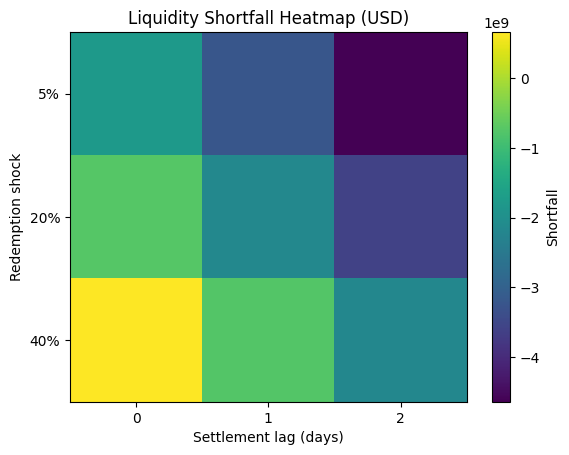

In [22]:
# Heatmap
import matplotlib.pyplot as plt

pivot = liq.pivot(index="redeem_pct", columns="settlement_days", values="shortfall")

plt.figure()
plt.imshow(pivot.values, aspect="auto")
plt.xticks(range(len(pivot.columns)), pivot.columns)
plt.yticks(range(len(pivot.index)), [f"{x:.0%}" for x in pivot.index])
plt.xlabel("Settlement lag (days)")
plt.ylabel("Redemption shock")
plt.title("Liquidity Shortfall Heatmap (USD)")
plt.colorbar(label="Shortfall")
plt.show()

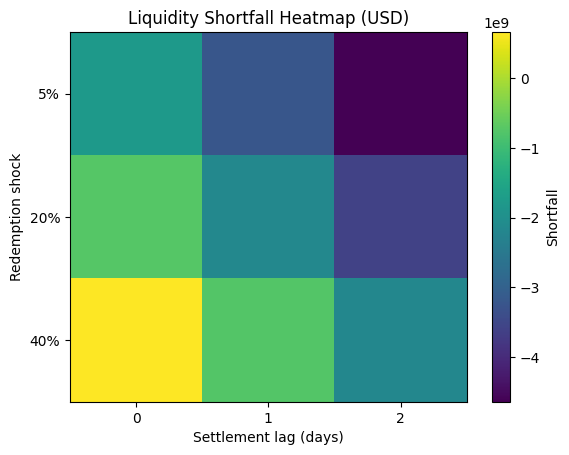

In [23]:
import os
os.makedirs("figures", exist_ok=True)
plt.figure()
plt.imshow(pivot.values, aspect="auto")
plt.xticks(range(len(pivot.columns)), pivot.columns)
plt.yticks(range(len(pivot.index)), [f"{x:.0%}" for x in pivot.index])
plt.xlabel("Settlement lag (days)")
plt.ylabel("Redemption shock")
plt.title("Liquidity Shortfall Heatmap (USD)")
plt.colorbar(label="Shortfall")
plt.savefig("figures/liquidity_shortfall_heatmap.png", dpi=200, bbox_inches="tight")
plt.show()